In [1]:
import cv2
import time, os
import matplotlib.pyplot as plt
import numpy as np
import multiprocessing as mp

import nbimporter
from utils import FPSTimes
from camera import WebcamStream
from video import VideoWriter
from position import PositionTracker
from sound import SoundController

### Test all controllers

In [8]:
# sound selector: 0 - silence, 1 - tone 1, 2 - tone 2
selector = mp.Value('i', 1)

# experiment status: 1 - idle, 2 - running (logging), 0 - stopped
status = mp.Value('i', 1)

# first start the camera stream
vs = WebcamStream(WebcamStream.default_cfg)
vs.start()

# recording video
vw = VideoWriter(status, vs, VideoWriter.default_cfg)
vw.start()

# tracking position
pt_cfg = PositionTracker.default_cfg
pt_cfg['background_file'] = os.path.join('..', 'assets', 'background.png')
pt = PositionTracker(status, vs, pt_cfg)
pt.start()

# playing sound in a separate process for performance
sc = mp.Process(target=SoundController.run, args=(selector, status, SoundController.default_cfg))
sc.start()

fps = FPSTimes()
names = ['camera', 'video', 'position', 'main']
try:
    while True:
        frame = vs.read()
        if frame is not None:
            fps.count()
            if pt.x is not None:
                cv2.circle(frame, (pt.x, pt.y), 3, (127, 255, 0), -1)
                
            for i, ctrl in enumerate([vs, vw, pt, fps]):
                frame = cv2.putText(frame, '%s: %.2f FPS' % (names[i], ctrl.get_avg_fps()), 
                         (10, 20 * (i+1)), cv2.FONT_HERSHEY_DUPLEX, .5, (255, 255, 255))
            
            cv2.imshow("Experiment", frame)

        k = cv2.waitKey(33)
        if k == ord('q'):
            break

        if k == ord('s'):
            status.value = 2 if status.value == 1 else 1

finally:
    status.value = 0
    time.sleep(0.01)
    cv2.destroyAllWindows()
    sc.join()
    for ctrl in [pt, vw, vs]:
        ctrl.stop()

Webcam stream 960.0:720.0 at 20.00 FPS started
Sound stopped
Position tracker stopped
Video writer stopped
Camera released


### Profiling FPS

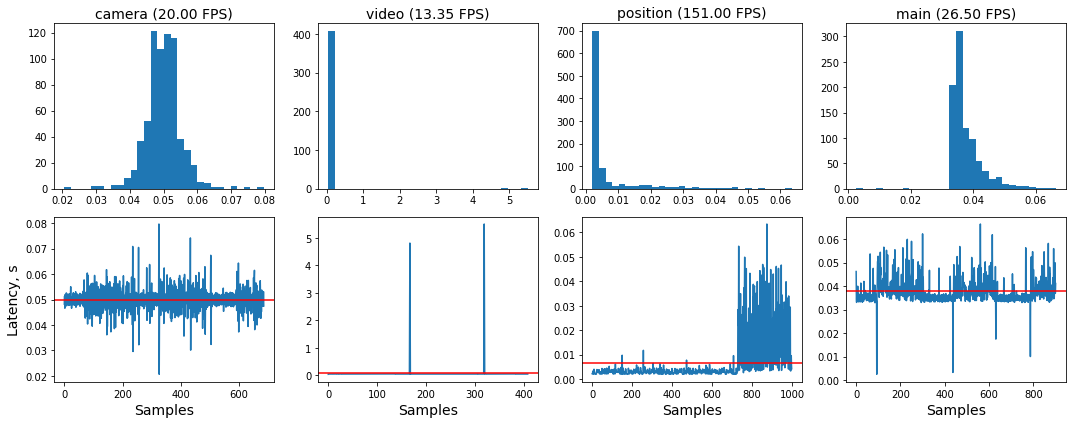

In [50]:
names = ['camera', 'video', 'position', 'main']
ctrls = [vs, vw, pt, fps]

fig, axes = plt.subplots(2, len(ctrls), figsize=(15,6))

for i, ctrl in enumerate(ctrls):
    diffs = ctrl.get_time_diffs()
    
    # latency histograms
    axes[0][i].hist(diffs, 30)
    axes[0][i].set_title('%s (%.2f FPS)' % (names[i], 1.0/diffs.mean()), fontsize=14)
    
    # latency plots
    axes[1][i].plot(diffs)
    axes[1][i].axhline(diffs.mean(), color='red')
    axes[1][i].set_xlabel('Samples', fontsize=14)
    if i == 0:
        axes[1][i].set_ylabel('Latency, s', fontsize=14)
    
fig.tight_layout()